<a href="https://colab.research.google.com/github/benliebersohn/alg-ds-lab2/blob/master/(M)GWR_tutorial_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GWR/MGWR example
***
This is an example notebook showing you how to calibrate a GWR and an MGWR model in Python using `mgwr` package.
***
We will be working on an example dataset of Georgia, and here are some variables in the table.

**TotPop90** Population of the county in 1990

**PctRural** Percentage of the county population defined as rural

**PctBach** Percentage of the county population with a bachelor’s degree

**PctEld** Percentage of the county population aged 65 or over

**PctFB** Percentage of the county population born outside the US

**PctPov** Percentage of the county population living below the poverty line

**PctBlack** Percentage of the county population who are black  


***
We will model the county-level educational attainment with several socio-demographic variables.  



The model is:  

PctBach = b0 + b1 * PctFB + b2 * PctBlack + b3 * PctRural



In [6]:
!pip install mgwr

In [7]:
import sys
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
import libpysal as ps


from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

In [28]:
#Load Georgia dataset
georgia_shp = gp.read_file(ps.examples.get_path('G_utm.shp'))

In [29]:
georgia_shp.head()

,AREA,PERIMETER,G_UTM_,G_UTM_ID,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,X,Y,AreaKey,geometry
0,1.331370e+09,207205.0,132,133,31.75339,-82.28558,15744,75.6,8.2,11.43,0.64,19.9,20.76,941396.6,3521764,13001,"POLYGON ((931869.062 3545540.500, 934111.625 3..."
1,8.929300e+08,154640.0,157,158,31.29486,-82.87474,6213,100.0,6.4,11.77,1.58,26.0,26.86,895553.0,3471916,13003,"POLYGON ((867016.312 3482416.000, 884309.375 3..."
2,7.434020e+08,130431.0,148,146,31.55678,-82.45115,9566,61.7,6.6,11.11,0.27,24.1,15.42,930946.4,3502787,13005,"POLYGON ((914656.875 3512190.000, 924718.375 3..."
3,9.053950e+08,185737.0,158,155,31.33084,-84.45401,3615,100.0,9.4,13.17,0.11,24.8,51.67,745398.6,3474765,13007,"POLYGON ((744258.625 3480598.500, 765025.062 3..."
4,6.941830e+08,151347.0,76,79,33.07193,-83.25085,39530,42.7,13.3,8.64,1.43,17.5,42.39,849431.3,3665553,13009,"POLYGON ((832974.188 3677273.500, 834048.688 3..."


<Axes: >

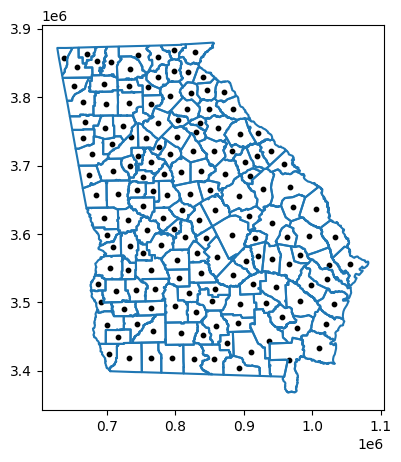

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
georgia_shp.boundary.plot(ax=ax)
georgia_shp.centroid.plot(ax=ax, c='black',markersize = 10)

A map of Georgia for reference
(source:https://www.enchantedlearning.com/usa/states/georgia/map.GIF)


<img src=https://www.enchantedlearning.com/usa/states/georgia/map.GIF width="200" align="left">

Text(0.5, 1.0, 'PctBach')

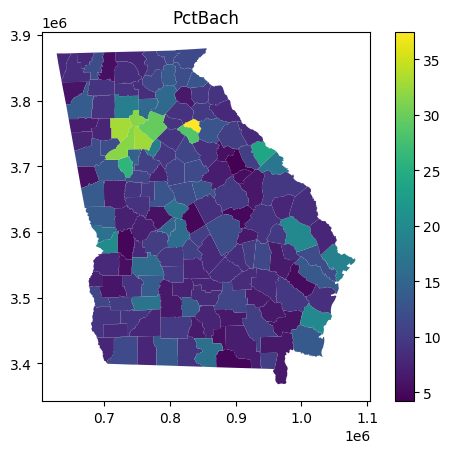

In [31]:
georgia_shp.plot(column="PctBach",legend=True)
plt.title("PctBach")

### Model specification:
PctBach = b0 + b1 * PctFB + b2 * PctBlack + b3 * PctRural

In [12]:
#Prepare Georgia dataset inputs
y = georgia_shp['PctBach'].values
X = georgia_shp[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia_shp['X']
v = georgia_shp['Y']

coords = list(zip(u,v))

### Standardizing varaibles
- Standardizing put the data at the same scale: mean of 0 and variance of 1
- The magnitudes of the parameter estimates are comparable. Larger magnitude -> stronger relationship
- If you calibrate an MGWR model, we have to standardize the data. Each bandwidth would describe the degree of spatial variation of each relationship.

In [13]:
#Standardize variables
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)
y = y.reshape(-1,1)

### Fitting a GWR model
- Select the optimal bandwidths
- Fit the model

In [14]:
#Select the optimal bandwidth
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=2)
print("Selected optimal bandwidth is:", gwr_bw)

Selected optimal bandwidth is: 117.0


In [15]:
#Fit the model using the optimal bw
gwr_results = GWR(coords, y, X, gwr_bw).fit()

In [16]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Write some mapping codes

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def gwr_plots(result, gdf, names=[], filter_t=False):

    fig, axs = plt.subplots(2,2, figsize=(10, 10))
    axs = axs.ravel()

    k = gwr_results.k

    vmin = -0.8
    vmax = 0.8

    cmap = cm.get_cmap("coolwarm")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.85,0.1),ncolors=256)

    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    else:
        cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

    for j in range(k):

        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap="bwr",norm=norm,linewidth=0.1,edgecolor='white')
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)

        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='lightgrey', ax=axs[j],linewidth=0.1,edgecolor='white')

        #plt.axis('off')

    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

#### Here are the maps of parameter estimates obtained from GWR. Each represent the spatial relationship between each predictor and PctBach.

#### Positive (negative) relationships are shown in red (blue).
#### Stronger relationship has a darker color.

In [26]:
#gwr_plots(gwr_results, georgia_shp,names=['intercept','PctFB', 'PctBlack', 'PctRural']) #needs fixed

#### Here are the maps of **SIGNIFICANT (p<0.05)** parameter estimates. Grey locations are insignificant.


In [27]:
#gwr_plots(gwr_results, georgia_shp,names=['intercept','PctFB', 'PctBlack', 'PctRural'],filter_t=True)

### Fitting the MGWR model
- Select the optimal bandwidths
- Fit the model

In [21]:
mgwr_selector = Sel_BW(coords, y, X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 92. 101. 136. 158.]


In [22]:
mgwr_results = MGWR(coords, y, X, mgwr_selector).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
mgwr_results.summary()

Model comparison


|      | OLS   | GWR   | MGWR |   |
|------|-------|-------|------|---|
| AICc | 335   | 299   | 297  |   |
| R2   | 0.548 | 0.678 | 0.68 |   |
|      |       |       |      |   |

In [ ]:
gwr_plots(mgwr_results, georgia_shp,names=['intercept','PctFB', 'PctBlack', 'PctRural'])

In [ ]:
gwr_plots(mgwr_results, georgia_shp,names=['intercept','PctFB', 'PctBlack', 'PctRural'],filter_t=True)